Внимательно прочтите эти инструкции. Выполнение **всех** этих пунктов - обязательно для получения баллов за задание.

1) Проверка
    - После того, как вы допишете код
        - очистите все клетки (`Cell > All Output > Clear`)
        - выполните все клетки подряд (`Cell > Run All`)
    - Выполнение должно пройти без ошибок
    - Сохраните ноутбук с выполненными клетками

<!-- -->

2) Отправка в тестовую систему
    - Когда вы готовы сдать ноутбук, загрузите его в тестовую систему (fall.cv-gml.ru)
    - В тестовую систему нужно загружать только сам `.ipynb` ноутбук
        - Не нужно его `zip`овать
        - Не нужно его конвертировать в `pdf` или `html`
    - После загрузки в тестовую систему там появится ссылка для просмотра загруженного решения
        - Проверьте, что вы загрузили в тестовую систему то, что хотели
        - Проверьте, что в системе отображаются результаты выполнения всех клеток

## NeRF

Необходимо реализовать базовую версию [NeRF](https://arxiv.org/pdf/2003.08934.pdf) не включающую иерархический семплинг (его тоже можно реализовать, если есть желание). Код загрузки данных вам предоставлен, рекомендуется внимательно его изучить.

Работы оцениваются по бинарному принципу (зачет/незачет).

In [1]:
%%bash

# Download dataset and helper library
for part in data lib; do
    if [ ! -d "${part}/" ]; then
        curl -sO "https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/neural-radiance-fields/${part}.zip"
        unzip -qo "${part}.zip"
    fi
done

# Install required dependencies
if ! pip freeze | grep -q nvdiffrast; then
    pip install -q \
        git+https://github.com/NVlabs/nvdiffrast.git \
        ninja xatlas trimesh \
        torch matplotlib
fi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nvdiffrast.torch as dr
import torch
import torch.nn.functional as F
glctx = dr.RasterizeCudaContext()

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [3]:
from lib.dataset import DatasetNERF

dataset = DatasetNERF(
    cfg="./data/hotdog/transforms_train.json",
    near=2.0,
    far=6.0,
    resolution=(160, 160),
    ray_mode=True,
)

In [ ]:
def ray_gen(imv, coords, focal, resolution):
    """
    Необходимо реализовать функцию генерации лучей по заданным параметрам камеры

        @params: imv -- матрица 4x4, преобразование Camera Frame -> World Frame
        @params: coords -- координаты пикселя, coords[..., 0] - w, coords[..., 1] - h
        @params: focal -- фокальное расстояние камеры
        @params: resolution -- H, W разрешение

        Return: rays_o, rays_d -- положение и направление лучей
    """
    H, W = resolution
    cx = W / 2.
    cy = H / 2.

    d_cam = torch.stack([
        coords[..., 0] - cx,
        -(coords[..., 1] - cy),
        -torch.full_like(coords[..., 0], focal)
    ], dim=-1)

    d_cam /= focal
    rays_o = imv[..., :3, 3]
    rays_d = (imv[..., :3, :3] @ d_cam.unsqueeze(-1)).squeeze(-1)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)

    return rays_o, rays_d

In [ ]:
def ray_color(
    ray_o,
    ray_d,
    radiance_field_fn,
    near,
    far,
    bins,
    train=True,
):
    """
    Необходимо реализовать функцию рендеринга лучей, согласно уравнению NeRF'a: https://arxiv.org/pdf/2003.08934.pdf

        @params: ray_o, ray_d -- положение и направления луча
        @params: radiance_field_fn -- функция, возврашающая color, sigma
        @params: near, far -- диапазон семплирования вдоль лучей
        @params: bins -- количество точек для семплирования

        Return: color -- интегрированный по лучам свет
    """
    N = ray_o.shape[0]

    t_vals = torch.linspace(near, far, bins, device=ray_o.device)

    if train:
        mids = (t_vals[:-1] + t_vals[1:]) / 2.
        upper = torch.cat([mids, t_vals[-1:]], -1)
        lower = torch.cat([t_vals[:1], mids], -1)
        t_rand = torch.rand(t_vals.shape, device=ray_o.device)
        t_vals = lower + (upper - lower) * t_rand

    pts = ray_o.unsqueeze(1) + ray_d.unsqueeze(1) * t_vals.view(1, bins, 1)
    pts_flat = pts.reshape(-1, 3)

    view_dirs = ray_d.unsqueeze(1).expand(-1, bins, -1).reshape(-1, 3)

    rgb, sigma = radiance_field_fn(pts_flat, view_dirs)
    rgb = rgb.reshape(N, bins, 3)
    sigma = sigma.reshape(N, bins, 1)
    delta = (far - near) / bins

    alpha = 1 - torch.exp(-sigma * delta)

    T = torch.cumprod(torch.cat([
        torch.ones((N, 1, 1), device=alpha.device),
        1 - alpha + 1e-10
    ], dim=1), dim=1)[:, :-1, :]

    weights = alpha * T
    color = (weights * rgb).sum(dim=1)

    return color

In [6]:
from functools import partial

def render_radiance_field(
    imv,
    coords,
    radiance_field_fn,
    focal,
    resolution,
    near=2.0,
    far=6.0,
    bins=64,
    train=True,
    chunk=1024,
):
    ray_gen_ = partial(
        ray_gen,
        focal=focal,
        resolution=resolution,
    )
    ray_color_ = partial(
        ray_color,
        radiance_field_fn=radiance_field_fn,
        near=near,
        far=far,
        bins=bins,
    )

    imv = (
        torch.tensor(imv, dtype=torch.float32, device="cuda")
        if not torch.is_tensor(imv)
        else imv
    ).cuda()

    if train:
        ray_o, ray_d = ray_gen_(imv, coords)
        color = ray_color_(ray_o, ray_d)

        return color

    with torch.no_grad():
        H, W = resolution
        u, v = torch.meshgrid(
            torch.linspace(0, H - 1, H),
            torch.linspace(0, W - 1, W),
            indexing="ij",
        )

        coords = torch.stack([v.flatten(), u.flatten()], dim=-1).cuda()
        ray_o, ray_d = ray_gen_(imv[0:1, ...], coords)
        ray_o = ray_o.expand([ray_d.shape[0], -1])

        steps = ray_o.shape[0] // chunk + (ray_o.shape[0] % chunk > 0)

        color = torch.cat(
            [
                ray_color_(
                    ray_o[i * chunk : (i + 1) * chunk],
                    ray_d[i * chunk : (i + 1) * chunk],
                )
                for i in range(steps)
            ],
            dim=0,
        )
        return color.view(*resolution, 3).permute(1, 0, 2)

In [ ]:
class VanillaNeRF(torch.nn.Module):
    """
    Реализуйте конфигурацию NeRF согласно статье: https://arxiv.org/pdf/2003.08934.pdf
    """

    def __init__(self, hidden_dim=256, num_pos_enc=10, num_dir_enc=4) -> None:
        super().__init__()
        self.num_pos_enc = num_pos_enc
        self.num_dir_enc = num_dir_enc
        self.pts_in_dim = 3 + 3 * 2 * num_pos_enc
        self.dir_in_dim = 3 + 3 * 2 * num_dir_enc

        self.pts_layers = torch.nn.Sequential(
            torch.nn.Linear(self.pts_in_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
        )
        # Выход по плотности
        self.sigma_layer = torch.nn.Linear(hidden_dim, 1)
        # Дополнительное представление для цвета
        self.feature_layer = torch.nn.Linear(hidden_dim, hidden_dim)
        # Ветка для учета направлений взгляда
        self.view_branch = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim + self.dir_in_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 3),
            torch.nn.Sigmoid()  # цвета в диапазоне [0, 1]
        )

    def positional_encoding(self, x, num_encoding_functions, include_input=True):
        """
        Применяет позиционное кодирование к входному тензору x.
        """
        encoding = [x] if include_input else []
        for i in range(num_encoding_functions):
            encoding.append(torch.sin((2.0 ** i) * x))
            encoding.append(torch.cos((2.0 ** i) * x))
        return torch.cat(encoding, dim=-1)

    def forward(self, rays_x, rays_d):
        """
        Return: color, sigma
        """
        rays_x_encoded = self.positional_encoding(rays_x, self.num_pos_enc, include_input=True)
        rays_d_encoded = self.positional_encoding(rays_d, self.num_dir_enc, include_input=True)

        x = self.pts_layers(rays_x_encoded)
        sigma = self.sigma_layer(x)
        feat = self.feature_layer(x)
        h = torch.cat([feat, rays_d_encoded], dim=-1)
        color = self.view_branch(h)
        return color, sigma

In [8]:
radiance_field = VanillaNeRF().cuda()
optimizer = torch.optim.Adam(list(radiance_field.parameters()), lr=5e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2048,
    shuffle=True,
    collate_fn=dataset.collate,
)

In [ ]:
########################################
########################################
#### Написать цикл Оптимизации NeRF ####
########################################
########################################
############## ####### #################
############## ####### #################
########### ############ ###############
############ ########## ################
############# ######## #################
############## ###### ##################
############### ### ####################
################ # #####################
########################################

num_epochs = 10
focal = dataset.focal
resolution = dataset.resolution

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, batch in enumerate(dataloader):
        imv = batch["imv"]
        coords = batch["coords"]
        target_color = batch["img"]

        pred_color = render_radiance_field(
            imv, coords, radiance_field, focal, resolution,
            near=dataset.near, far=dataset.far, bins=64, train=True
        )

        loss = F.mse_loss(pred_color, target_color)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if i % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.6f}")
    print(f"Epoch {epoch+1} average loss: {epoch_loss/len(dataloader):.6f}")

Epoch 1, Batch 0, Loss: 0.030378
Epoch 1, Batch 50, Loss: 0.014843
Epoch 1, Batch 100, Loss: 0.013661
Epoch 1, Batch 150, Loss: 0.010412
Epoch 1, Batch 200, Loss: 0.008328
Epoch 1, Batch 250, Loss: 0.007998
Epoch 1, Batch 300, Loss: 0.005987
Epoch 1, Batch 350, Loss: 0.005254
Epoch 1, Batch 400, Loss: 0.004864
Epoch 1, Batch 450, Loss: 0.004237
Epoch 1, Batch 500, Loss: 0.004399
Epoch 1, Batch 550, Loss: 0.003941
Epoch 1, Batch 600, Loss: 0.003816
Epoch 1, Batch 650, Loss: 0.003374
Epoch 1, Batch 700, Loss: 0.003147
Epoch 1, Batch 750, Loss: 0.003251
Epoch 1, Batch 800, Loss: 0.002927
Epoch 1, Batch 850, Loss: 0.002821
Epoch 1, Batch 900, Loss: 0.003272
Epoch 1, Batch 950, Loss: 0.002524
Epoch 1, Batch 1000, Loss: 0.002208
Epoch 1, Batch 1050, Loss: 0.002243
Epoch 1, Batch 1100, Loss: 0.002282
Epoch 1, Batch 1150, Loss: 0.002079
Epoch 1, Batch 1200, Loss: 0.001977
Epoch 1 average loss: 0.005371
Epoch 2, Batch 0, Loss: 0.002128
Epoch 2, Batch 50, Loss: 0.002099
Epoch 2, Batch 100, Loss:

Ожидаемый результат (после первой эпохи):

<img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/neural-radiance-fields/ref_epoch0.png" style="display: inline-block; text-align: left;"/>

```
epoch: 0, loss=0.002454527420923114
```

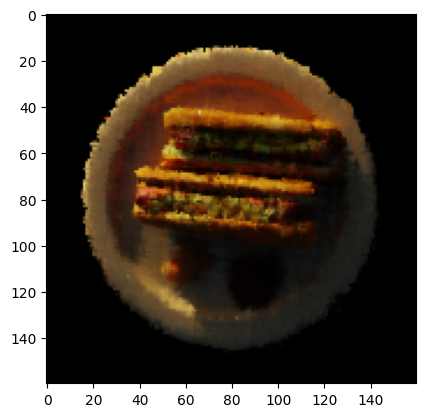

In [10]:
c = render_radiance_field(
    dataset[0]["imv"],
    None,
    radiance_field,
    dataset.focal,
    dataset.resolution,
    dataset.near,
    dataset.far,
    train=False,
)
plt.imshow(c.detach().cpu());

Ожидаемый результат (после обучения):

<img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/neural-radiance-fields/ref_final.png" style="display: inline-block; text-align: left;"/>

```
loss=0.00013125527766533196
```